## 매출에 영향력 높은 후행 지표 찾기

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# base_path = "C:/Users/dukkubi"
# df = pd.read_csv(base_path + "영업팀 매출 데이터.csv")
# form = pd.read_csv(base_path + "피터팬의 좋은방구하기 입점문의 접수(응답).csv")
# agent = pd.read_csv(base_path + "중개사 데이터.csv")
# first_party_db = pd.read_csv(base_path + "first_party_db.csv")

##### 예시 데이터

In [6]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# 랜덤 데이터 생성을 위한 seed 설정
random.seed(42)

# 데이터 크기 설정
num_rows = 1000

# 데이터 생성
regions = ['서울 중구', '서울특별시 강남구', '서울시 도봉구', '부산 서구', '부산광역시 동구', '대구 ', '광주 남구', '대전', '울산', '인천', '제주 서귀포시']
companies = ['피터팬의좋은방구하기 공인중개사', '피터팬의 좋은방구하기 공인중개사', '피터팬의좋은방구하기', '피터팬의좋은방구하기 중개사', '피터팬의좋은방구하기 부동산', '피터팬의좋은방구하기 사무소',
             '직방 공인중개사', '직방 공인중개사', '직방', '직방 중개사', '직방 부동산', '직방 사무소',
             '다방 공인중개사', '다방 공인중개사', '다방', '다방 중개사', '다방 부동산', '다방사무소',
             '한방 공인중개사', '한방 공인중개사', '한방', '한방 중개사', '한방 부동산', '한방 부동산사무소',
             '부동산119 공인중개사', '부동산119 공인중개사', '부동산119', '부동산119 중개사', '부동산119 부동산',
             '리치고 공인중개사', '리치고 공인중개사', '리치고', '리치고 중개사', '리치고 부동산',
             ]
persons = ['김건영', '김건영 ', '김건영(대표자)', ' 김건영', ' 김건영 ',
           '중개사1', '중개사2', '중개사3', '중개사4', '중개사5', '중개사6', '중개사7', '중개사8'
             ]

# 열 데이터 생성
지역 = np.random.choice(regions, num_rows)
상호 = np.random.choice(companies, num_rows)
대표자 = np.random.choice(persons, num_rows)

# 다양한 형식의 매출액 데이터 생성
매출액 = [
    random.choice([
        random.randint(10000, 1000000),  # 숫자
        '',  # 빈 문자열
        f"{random.randint(1000, 1000000):,}",  # 쉼표 포함 숫자
        f"-{random.randint(1000, 100000)}"  # 음수
    ]) for _ in range(num_rows)
]

# 음수 매출액의 경우 '환불'로 설정
def generate_신규연장(value):
    if isinstance(value, str) and value.startswith('-'):
        return '환불'
    return np.random.choice(['신규', '연장', None], p=[0.5, 0.4, 0.1])

신규연장 = [generate_신규연장(value) for value in 매출액]

날짜 = [(datetime.today() - timedelta(days=random.randint(0, 365 * 2))).strftime('%Y-%m-%d') for _ in range(num_rows)]
register_numbers = [f"RN{str(i).zfill(6)}" for i in range(1, num_rows + 1)]

# 데이터프레임 생성
df = pd.DataFrame({
    '지역': 지역,
    '상호': 상호,
    '대표자': 대표자,
    '매출액': 매출액,
    '날짜': 날짜,
    '신규연장': 신규연장
})

# first_party_db 생성
first_party_db = pd.DataFrame({
    '지역': df['지역'],
    '상호': df['상호'],
    '대표자': df['대표자'],
    'register_number': register_numbers
}).drop_duplicates()

### 1. 전처리

#### 1-1. 중개사 식별 key 만들기
영업팀 매출 데이터에 중개사를 식별하는 key가 존재하지 않는다.<br>
따라서, 지역 + 상호 + 대표자 데이터를 공공 데이터의 지역 + 상호 + 대표자와 join 하여 등록번호를 부여했다.<br>
공공 데이터의 경우, vworld 사이트에서 중개사 데이터를 크롤링 후, MySQL에 적재하였다.

**정규식으로 전처리**<br>
영업팀 매출 시트 데이터에서 아래에 해당하는 부분만 제거

상호
- 공인
- 중개사
- 중개
- 사무소
- 부동산
- 법인
- 법인분
- 공백 앞,뒤,가운데
- 주식회사
- 분사무소
- (주)
- 괄호 + 괄호 안에 문자
- .
- 선발행요청
- 소문자는 전부 대문자로 변경


대표자 이름
- 앞뒤공백
- 대괄호 + 괄호 안에 문자
- 소괄호() + 괄호 안에 문자
- (뒤에 문자 제거
 [뒤에 문자 제거


시도
- 광역
- 특별
- 경기도

In [7]:
import re

def preprocess_sangho(text):
    try:
        if isinstance(text, str):
            # 정규식 패턴들
            patterns = [
                r'(공인|중개사|중개|분사무소|사무소|부동산|법인분|법인|주식회사)',
                r'\([^()]*\)',  # 괄호와 괄호 안의 문자 모두 삭제
                r'\s+',
                r'\.',          # 점 삭제
                r'선발행요청'
            ]

            # 각 패턴을 제거하고 대문자로 변환
            for pattern in patterns:
                text = re.sub(pattern, '', text)

            # 대문자로 변환
            text = text.upper()
    except Exception as e:
        pass

    return text


def preprocess_name(text):
    try:
        if isinstance(text, str):
            # 정규식 패턴들
            patterns = [
                r'\s+',  # 공백 제거
                r'\[(.*?)\]',  # 대괄호 안의 문자 제거
                r'\((.*?)\)',  # 소괄호 안의 문자 제거
                r'\(([^()]*)$',  # 소괄호 뒤에 문자 제거
                r'\[([^[\]]*)$'  # 대괄호 뒤에 문자 제거
            ]

            # 각 패턴을 제거하고 대문자로 변환
            for pattern in patterns:
                text = re.sub(pattern, '', text)

    except Exception as e:
        pass

    return text


def preprocess_sido(text):
    try:
        if isinstance(text, str):
            # 정규식 패턴들
            patterns = [
                r'\s+',  # 공백 제거,
                r'광역|특별|경기도|시'
            ]

            # 각 패턴을 제거
            for pattern in patterns:
                text = re.sub(pattern, '', text)

    except Exception as e:
        pass

    return text

In [8]:
# 테스트 문자열
text = "aAg 하남(주)중개사중개 (하남) 사무소 부동산 법인 법인분 주식회사 분사무소 . 선발행요청"

# 전처리된 문자열 출력
print(preprocess_sangho(text))

AAG하남


In [9]:
# 테스트 문자열
text = "김건영[건영킴](건영킴) (11 [22 (33 )"

# 전처리된 문자열 출력
print(preprocess_name(text))

김건영


In [10]:
# 테스트 문자열
text = "서울특별시 강남구 특별시 서울 도봉구 서울시 경기도 수원시 광역시 부산광역시 해운대구 대구광역시 광주광역시 서울특별시 제주도 서귀포시"

# 전처리된 문자열 출력
print(preprocess_sido(text))

서울강남구서울도봉구서울수원부산해운대구대구광주서울제주도서귀포


In [11]:
# 정규식 적용
df['상호'] = df['상호'].apply(lambda x: preprocess_sangho(x))
df['대표자'] = df['대표자'].apply(lambda x: preprocess_name(x))
df['지역'] = df['지역'].apply(lambda x: preprocess_sido(x))

first_party_db['상호'] = first_party_db['상호'].apply(lambda x: preprocess_sangho(x))
first_party_db['대표자'] = first_party_db['대표자'].apply(lambda x: preprocess_name(x))
first_party_db['지역'] = first_party_db['지역'].apply(lambda x: preprocess_sido(x))

In [12]:
# 지역 + 상호 + 대표자 합치기
df['지역 상호 대표자'] = df['지역'] + ' ' + df['상호'] + ' ' + df['대표자']
first_party_db['지역 상호 대표자'] = first_party_db['지역'] + ' ' + first_party_db['상호'] + ' ' + first_party_db['대표자']
print(len(df['지역 상호 대표자'].unique()), len(first_party_db['지역 상호 대표자'].unique()))

415 415


In [13]:
# 데이터 이상 없는지 학인
print(df['지역'].unique(), "\n", df['상호'].unique(), "\n", df['대표자'].unique())

['서울중구' '서울강남구' '울산' '제주서귀포' '대구' '서울도봉구' '부산서구' '부산동구' '광주남구' '인천' '대전'] 
 ['피터팬의좋은방구하기' '다방' '리치고' '119' '직방' '한방'] 
 ['중개사3' '중개사4' '중개사6' '김건영' '중개사5' '중개사2' '중개사8' '중개사1' '중개사7']


In [14]:
# 영업팀 매출 시트와 vworld 공공 데이터를 '지역 + 상호 + 대표자' 기준으로 left join
df['지역 상호 대표자'] = df['지역']  + ' ' + df['상호'] + ' ' + df['대표자']

first_party_db['지역 상호 대표자'] = df['지역']  + ' ' + df['상호'] + ' ' + df['대표자']
first_party_db = first_party_db[['지역 상호 대표자', 'register_number']]

df = df.merge(first_party_db, on='지역 상호 대표자', how='left')
df

,지역,상호,대표자,매출액,날짜,신규연장,지역 상호 대표자,register_number
0,서울중구,피터팬의좋은방구하기,중개사3,"117,739",2024-11-17,신규,서울중구 피터팬의좋은방구하기 중개사3,RN000001
1,서울강남구,다방,중개사4,266787,2023-09-08,연장,서울강남구 다방 중개사4,RN000002
2,서울중구,리치고,중개사6,719570,2023-12-28,None,서울중구 리치고 중개사6,RN000003
3,울산,리치고,중개사3,629176,2023-12-08,None,울산 리치고 중개사3,RN000004
4,울산,리치고,중개사3,629176,2023-12-08,None,울산 리치고 중개사3,RN000948
...,...,...,...,...,...,...,...,...
4133,서울도봉구,피터팬의좋은방구하기,김건영,249499,2023-02-18,신규,서울도봉구 피터팬의좋은방구하기 김건영,RN000478
4134,서울도봉구,피터팬의좋은방구하기,김건영,249499,2023-02-18,신규,서울도봉구 피터팬의좋은방구하기 김건영,RN000812
4135,서울도봉구,피터팬의좋은방구하기,김건영,249499,2023-02-18,신규,서울도봉구 피터팬의좋은방구하기 김건영,RN000999
4136,제주서귀포,119,중개사2,,2023-08-17,연장,제주서귀포 119 중개사2,RN000765


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4138 entries, 0 to 4137
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   지역               4138 non-null   object
 1   상호               4138 non-null   object
 2   대표자              4138 non-null   object
 3   매출액              4138 non-null   object
 4   날짜               4138 non-null   object
 5   신규연장             3854 non-null   object
 6   지역 상호 대표자        4138 non-null   object
 7   register_number  4138 non-null   object
dtypes: object(8)
memory usage: 291.0+ KB


#### 1-2. 매출액 전처리

In [16]:
df['매출액']

0       117,739
1        266787
2        719570
3        629176
4        629176
         ...   
4133     249499
4134     249499
4135     249499
4136           
4137           
Name: 매출액, Length: 4138, dtype: object

In [17]:
# 매출액 전처리 함수
def preprocess_sales(sales):
    try:
        # 빈 문자열은 0으로 처리
        if sales == '':
            return 0
        # 문자열일 경우 쉼표 제거 후 숫자로 변환
        if isinstance(sales, str):
            return int(sales.replace(',', ''))
        # 이미 숫자인 경우 그대로 반환
        return int(sales)
    except ValueError:
        # 변환 실패 시 NaN 반환
        return np.nan

# 매출액 열 전처리
df['매출액'] = df['매출액'].apply(preprocess_sales)

# 결과 출력
print(df['매출액'])

0       117739
1       266787
2       719570
3       629176
4       629176
         ...  
4133    249499
4134    249499
4135    249499
4136         0
4137         0
Name: 매출액, Length: 4138, dtype: int64


#### 1-3. '신규연장' 열에 데이터가 없는 경우 '신규' 인지, '연장'인지 
- '신규연장' 열은 최초구매 데이터인지, 재구매 데이터인지, 환불 데이터인지를 구분해주는 Columns이다.

In [18]:
df['신규연장'].value_counts(dropna=False)

신규     1396
연장     1341
환불     1117
NaN     284
Name: 신규연장, dtype: int64

In [19]:
# '신규연장' Column이 Null값인 중개사들의 최초구매날짜 계산
nan_agent_list = df.loc[df['신규연장'].isna(), 'register_number'].unique().tolist()
nan_agent_first_purchase_date = df.loc[df['register_number'].isin(nan_agent_list)].groupby(['register_number'])['날짜'].min().reset_index().rename(columns={'날짜':'최초구매날짜'})
nan_agent_first_purchase_date.head()

,register_number,최초구매날짜
0,RN000003,2023-12-28
1,RN000004,2023-12-08
2,RN000006,2023-01-20
3,RN000009,2023-03-04
4,RN000016,2023-07-05


In [20]:
# 기존 데이터에 merge
df_merge_first_purchase = df.merge(nan_agent_first_purchase_date, how='left', on='register_number')
df_merge_first_purchase.loc[(~df_merge_first_purchase['최초구매날짜'].isna()) & df_merge_first_purchase['신규연장'].isna()]

,지역,상호,대표자,매출액,날짜,신규연장,지역 상호 대표자,register_number,최초구매날짜
2,서울중구,리치고,중개사6,719570,2023-12-28,None,서울중구 리치고 중개사6,RN000003,2023-12-28
3,울산,리치고,중개사3,629176,2023-12-08,None,울산 리치고 중개사3,RN000004,2023-12-08
4,울산,리치고,중개사3,629176,2023-12-08,None,울산 리치고 중개사3,RN000948,2023-12-08
160,대구,한방,김건영,638038,2023-12-23,None,대구 한방 김건영,RN000046,2023-03-02
161,대구,한방,김건영,638038,2023-12-23,None,대구 한방 김건영,RN000064,2023-03-02
...,...,...,...,...,...,...,...,...,...
4077,서울강남구,피터팬의좋은방구하기,김건영,0,2024-07-23,None,서울강남구 피터팬의좋은방구하기 김건영,RN000507,2023-09-14
4078,서울강남구,피터팬의좋은방구하기,김건영,0,2024-07-23,None,서울강남구 피터팬의좋은방구하기 김건영,RN000920,2023-09-14
4079,서울강남구,피터팬의좋은방구하기,김건영,0,2024-07-23,None,서울강남구 피터팬의좋은방구하기 김건영,RN000984,2023-09-14
4088,인천,직방,중개사5,0,2024-06-05,None,인천 직방 중개사5,RN000904,2024-06-05


In [21]:
# 조건에 맞게 '신규연장' 컬럼 생성
df_merge_first_purchase['신규연장'] = df_merge_first_purchase.apply(
    lambda row: '신규' if pd.to_datetime(row['날짜']) == pd.to_datetime(row['최초구매날짜']) 
    else ('연장' if pd.to_datetime(row['날짜']) > pd.to_datetime(row['최초구매날짜']) else row['신규연장']),
    axis=1
)

In [22]:
# Null값 전부 채워졌는지 확인
df_merge_first_purchase['신규연장'].value_counts(dropna=False)

연장    2091
신규    1226
환불     821
Name: 신규연장, dtype: int64

In [75]:
# '최추구매날짜' 열 삭제 후, 다시 df로 대체
df = df_merge_first_purchase.drop('최초구매날짜', axis=1)

### 2. 매출 분석

2-1. 구매주기 계산

In [76]:
df_minus = df.loc[df['신규연장'] == '환불']
df_plus = df.loc[df['신규연장'] != '환불']

In [62]:
# register 기준으로 구매 날짜의 차이 구하기

df_plus['날짜'] = pd.to_datetime(df_plus['날짜'])

# register_number별 정렬
df_plus = df_plus.sort_values(by=['register_number', '날짜'])

# register_number별 년월 차분 계산
df_plus['차이'] = df_plus.groupby('register_number')['날짜'].diff().dt.days

In [63]:
df_plus['차이'].mean()

111.96352201257862

In [64]:
df_plus['차이'].median()

73.0

<AxesSubplot:xlabel='차이', ylabel='Count'>

c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)


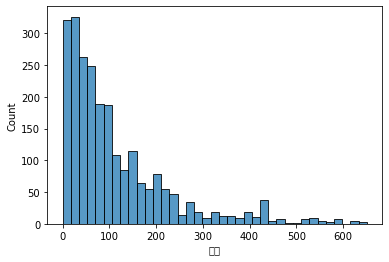

In [65]:
import seaborn as sns
sns.histplot(df_plus['차이'])

In [77]:
# 평균 환불 기간 계산
df['날짜'] = pd.to_datetime(df['날짜'])

# register_number별 정렬
df = df.sort_values(by=['register_number', '날짜'])

# register_number별 날짜 차분 계산
df['차이'] = df.groupby('register_number')['날짜'].diff().dt.days

df_minus = df.loc[df['신규연장'] == '환불']

In [79]:
df_minus['차이'].mean()

130.0408163265306

In [80]:
df_minus['차이'].median()

87.0

<AxesSubplot:xlabel='차이', ylabel='Count'>

c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)


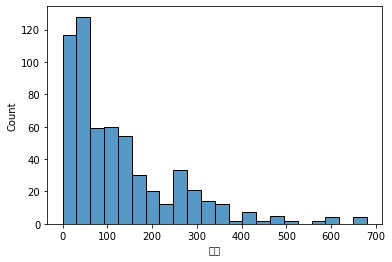

In [ ]:
sns.histplot(df_minus['차이'])

# 해석 구메 주기가 평균보다 14일 ~ 19일 늦어지면, 환불을 할 가능성이 높아진다.

#### 2-1. 신규가입 중개사 vs 재계약(연장) 중개사 비교
아래 두 그룹을 비교. 즉, 연장 매출이 신규 매출에 비해 어느정도 높거나 낮은지를 비교.
- 첫구매날짜를 기준으로 최초 구매 시점의 매출 합을 계산
- 첫구매날짜를 기준으로 총 연장 매출의 합을 계산

2-1-1. 환불 / 신규, 연장 분리

In [25]:
df_minus = df.loc[df['신규연장'] == '환불']
df_plus = df.loc[df['신규연장'] != '환불']

2-2-2. 신규유저, 현재 유저, 휴먼유저, 복귀유저로 구분
조건
- 신규유저: 첫 구매를 한 이후 3개월 이내에 재구매를 하지 않았고, 4개월이 지나지 않은 유저.
- 현재유저: 첫 구매 이후 3개월 이내에 재구매한 유저
- 휴먼유저: 첫 구매 이후 3개월 이내에 재구매를 하지 않은 유저
- 복귀유저: 휴면유저였다가 다시 구매를 한 유저

In [26]:
# 중개사별 첫 구매 날짜(한 중개사 당 '신규'가 2번 이상일 경우 가장 처음 날짜를 '첫구매날짜'로 선택)
frist_purchase_date = df_plus.loc[df_plus['신규연장'] =='신규'].groupby('register_number')['날짜'].min().reset_index().rename(columns={'날짜':'첫구매날짜'})

# 기존 데이터에 join
df_plus = df_plus.merge(frist_purchase_date, on='register_number', how='left')

# 월 단위로 변경
df_plus['첫구매날짜'] =  pd.to_datetime(df_plus['첫구매날짜']).dt.strftime('%Y-%m')

# 연장경과개월 = 연장 년월 - 첫 구매 년월 계산
df_plus['연장경과개월'] = (
    (pd.to_datetime(df_plus['날짜']).dt.year - pd.to_datetime(df_plus['첫구매날짜'], format='%Y-%m').dt.year) * 12 +
    (pd.to_datetime(df_plus['날짜']).dt.month - pd.to_datetime(df_plus['첫구매날짜'], format='%Y-%m').dt.month)
)

In [27]:
df_plus.loc[df_plus['연장경과개월'] < 0]

,지역,상호,대표자,매출액,날짜,신규연장,지역 상호 대표자,register_number,첫구매날짜,연장경과개월
55,인천,피터팬의좋은방구하기,중개사2,0,2024-09-03,연장,인천 피터팬의좋은방구하기 중개사2,RN000020,2024-12,-3.0
56,인천,피터팬의좋은방구하기,중개사2,0,2024-09-03,연장,인천 피터팬의좋은방구하기 중개사2,RN000562,2024-12,-3.0
120,광주남구,직방,김건영,534902,2023-04-07,연장,광주남구 직방 김건영,RN000043,2023-05,-1.0
121,광주남구,직방,김건영,534902,2023-04-07,연장,광주남구 직방 김건영,RN000129,2023-05,-1.0
122,광주남구,직방,김건영,534902,2023-04-07,연장,광주남구 직방 김건영,RN000333,2023-05,-1.0
...,...,...,...,...,...,...,...,...,...,...
3224,서울강남구,직방,중개사3,71813,2024-06-13,연장,서울강남구 직방 중개사3,RN000313,2024-11,-5.0
3225,서울강남구,직방,중개사3,71813,2024-06-13,연장,서울강남구 직방 중개사3,RN000450,2024-11,-5.0
3226,서울강남구,직방,중개사3,71813,2024-06-13,연장,서울강남구 직방 중개사3,RN000976,2024-11,-5.0
3294,서울강남구,리치고,중개사3,478309,2023-02-16,연장,서울강남구 리치고 중개사3,RN000968,2023-04,-2.0


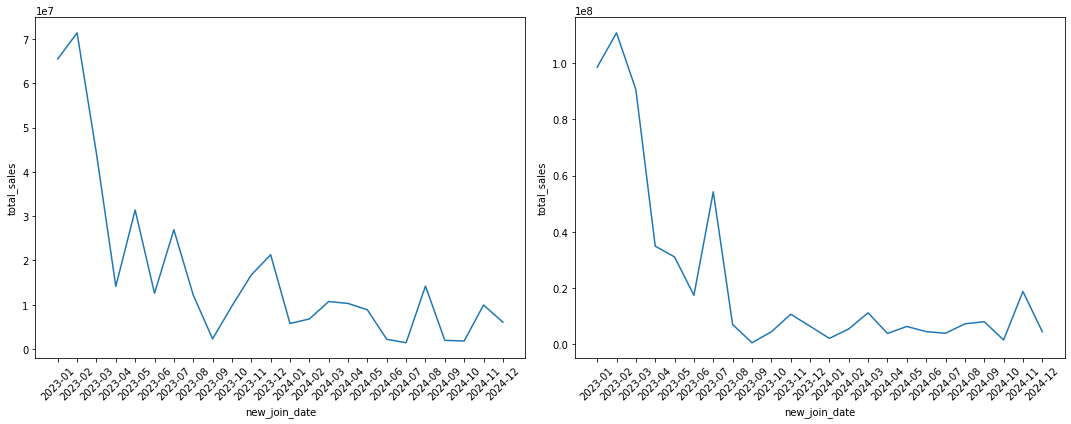

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

new_sales = df_plus.loc[df_plus['신규연장'] == '신규'].groupby('첫구매날짜')['매출액'].sum().reset_index().rename(columns={'첫구매날짜':'new_join_date', '매출액':'total_sales'})
extend_sales = df_plus.loc[df_plus['신규연장'] == '연장'].groupby('첫구매날짜')['매출액'].sum().reset_index().rename(columns={'첫구매날짜':'new_join_date', '매출액':'total_sales'})

fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.lineplot(data=new_sales, x='new_join_date', y='total_sales', ax=ax[0])
sns.lineplot(data=extend_sales, x='new_join_date', y='total_sales', ax=ax[1])

# x축 라벨을 45도 기울이기
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()  # 레이아웃 조정
plt.show()

In [29]:
df = df_plus

In [30]:
df.loc[df['첫구매날짜'] == '2024-11']

,지역,상호,대표자,매출액,날짜,신규연장,지역 상호 대표자,register_number,첫구매날짜,연장경과개월
0,서울중구,피터팬의좋은방구하기,중개사3,117739,2024-11-17,신규,서울중구 피터팬의좋은방구하기 중개사3,RN000001,2024-11,0.0
24,서울도봉구,리치고,중개사4,472029,2024-11-28,신규,서울도봉구 리치고 중개사4,RN000007,2024-11,0.0
73,부산동구,한방,중개사8,70403,2024-11-17,신규,부산동구 한방 중개사8,RN000027,2024-11,0.0
236,부산서구,직방,김건영,857272,2024-11-03,연장,부산서구 직방 김건영,RN000073,2024-11,0.0
237,부산서구,직방,김건영,857272,2024-11-03,연장,부산서구 직방 김건영,RN000180,2024-11,0.0
...,...,...,...,...,...,...,...,...,...,...
3083,대전,직방,중개사8,620224,2024-11-15,신규,대전 직방 중개사8,RN000930,2024-11,0.0
3223,서울강남구,직방,중개사3,71813,2024-06-13,연장,서울강남구 직방 중개사3,RN000184,2024-11,-5.0
3224,서울강남구,직방,중개사3,71813,2024-06-13,연장,서울강남구 직방 중개사3,RN000313,2024-11,-5.0
3225,서울강남구,직방,중개사3,71813,2024-06-13,연장,서울강남구 직방 중개사3,RN000450,2024-11,-5.0


In [31]:
# 신규 가입 중개사 수와 재개약(연장) 중개사 수 비교 
print(df.groupby('신규연장', dropna=False).size().reset_index(name='count'))

# 신규 가입 중개사의 매출과 연장 중개사의 매출 비교
print(df.groupby('신규연장', dropna=False)['매출액'].sum().reset_index())

  신규연장  count
0   신규   1226
1   연장   2091
  신규연장        매출액
0   신규  408192759
1   연장  605157270


연장 중개사 수, 매출 비율이 더 높은 점을 확인했다.<br>
평균적으로 중개사가 몇 개월 단위로, 몇 회 연장을 하는지도 확인을 해야한다.<br>
<br>
ex) 1개월 당 꾸준히 100명의 신규 중개사 유입
- 평균 연장 횟수: 3회
- 1회 연장 당 평균적으로 걸리는 기간: 3개월<br>

위 조건에서 작년 이번 달 처음 100명의 신규 중개사가 유입되었다고 가정하면 다음과 같은 결과가 나온다.

- 1개월 뒤 : 신규 중개사 100명, 연장 중개사 0명
- 2개월 뒤 : 신규 중개사 100명, 연장 중개사 0명
- 3개월 뒤 : 신규 중개사 100명, 연장 중개사 100명
- 4개월 뒤 : 신규 중개사 100명, 연장 중개사 100명
- 5개월 뒤 : 신규 중개사 100명, 연장 중개사 100명
- 6개월 뒤 : 신규 중개사 100명, 연장 중개사 200명
- 7개월 뒤 : 신규 중개사 100명, 연장 중개사 200명
- 8개월 뒤 : 신규 중개사 100명, 연장 중개사 200명
- 9개월 뒤 : 신규 중개사 100명, 연장 중개사 300명
- 10개월 뒤 : 신규 중개사 100명, 연장 중개사 300명
- 11개월 뒤 : 신규 중개사 100명, 연장 중개사 300명
- 12개월 뒤 : 신규 중개사 100명, 연장 중개사 300명

#### 2-2. 평균 연장 횟수 구하기
**계산 조건**
- 일반적으로 중개사는 3개월 단위로 연장을 하기 때문에 같은 달에 안에서는 여러번 연장을 했어도 1회로 간주(이 경우 재구매(연장)가 아니라 여러번 끊어서 구매했을 확률이 높음)
- 최초구매일 기준으로 12개월치 데이터만 가지고 계산<br>
-> 단순히 최근 2년치 데이터를 전부 가지고 평균을 계산하면, 1개월 전에 신규로 등록한 중개사의 경우 당연히 연장 횟수가 최대 1회일 수밖에 없다.<br>
따라서, 12개월치의 데이터만 추출하여 평균 연장 횟수를 계산했다.<br>
ex) 11개월 전 ~ 현재까지 신규로 등록한 중개사 데이터 제외, 그 이전에 신규로 등록한 중개사는 최대 12개월치 데이터만 가지고 계산

In [32]:
from datetime import date
from dateutil.relativedelta import relativedelta

## 평균 연장 횟수

# 중개사별 첫 구매 날짜
first_purchase_date = df.loc[df['신규연장'] == '신규', ['날짜', 'register_number']].rename(columns={'날짜': '첫구매날짜'})

# 월 단위로 변경
first_purchase_date['첫구매날짜'] =  pd.to_datetime(first_purchase_date['첫구매날짜']).dt.strftime('%Y-%m')

# 기존 데이터에 첫 구매 날짜 join
df = df.merge(first_purchase_date, on='register_number', how='left')

# 연장 날짜 - 첫 구매 날짜 계산
df['연장경과개월'] = (
    (pd.to_datetime(df['날짜']).dt.year - pd.to_datetime(df['첫구매날짜'], format='%Y-%m').dt.year) * 12 +
    (pd.to_datetime(df['날짜']).dt.month - pd.to_datetime(df['첫구매날짜'], format='%Y-%m').dt.month)
)

# 첫 구매일로부터 1개월 단위로 연장한 횟수
df_cohort = df.groupby(['첫구매날짜', '연장경과개월'])['register_number'].nunique().reset_index()

# 11개월 경과까지의 데이터만 선택. 12개월치 데이터가 없는 중개사는 선택 X
year_month_of_12_ago = (date.today() - relativedelta(months=12)).strftime('%Y-%m')
condition1 = (df_cohort['연장경과개월'] < 12)
condition2 = (df_cohort['첫구매날짜'] <= year_month_of_12_ago)
condition3 = (df_cohort['연장경과개월'] != 0)
df_cohort = df_cohort.loc[condition1 & condition2 & condition3]

# 평균 연장 횟수
년월기준신규중개사수 = df_cohort.loc[df_cohort['연장경과개월'] == 1].groupby('첫구매날짜')['register_number'].sum().reset_index()['register_number'].sum()
년월기준연장중개사수 = df_cohort.loc[df_cohort['연장경과개월'] != 1].groupby('첫구매날짜')['register_number'].sum().reset_index()['register_number'].sum()
print("평균연장횟수:", 년월기준연장중개사수/년월기준신규중개사수)

KeyError: '첫구매날짜'

#### 2-3. 1회 연장 당 평균적으로 걸리는 기간 
- 월 단위로 계산. 같은 달에 연장을 한 경우는 제외 하고 계산(제외하지 않은 경우도 계산해보았음)
- SQL의 윈도우 함수와 같은 방식으로 적용
SELECT register_number, TIMESTAMPDIFF(MONTH, 년월) OVER (PARTITION BY register_number
					   ORDER BY 년월 ACS
					   ROWS PRECENDING) AS month_diff<br>
FROM df

In [345]:
import pandas as pd

# '년월' 컬럼 생성
df['년월'] = pd.to_datetime(df['날짜']).dt.strftime('%Y-%m')

# '년월' 컬럼이 이미 datetime 형식이 아니면 datetime 형식으로 변환
df['년월'] = pd.to_datetime(df['년월'], errors='coerce')

# 'register_number'와 '년월' 기준으로 정렬
df = df.sort_values(by=['register_number', '년월'])

# 두 날짜 간의 차이를 월 단위로 계산하는 함수
def month_diff(start_date, timedelta):
    if pd.notna(start_date) and pd.notna(timedelta):
        end_date = start_date + timedelta  # start_date에 timedelta를 더하여 end_date를 계산
        return (end_date.year - start_date.year) * 12 + end_date.month - start_date.month
    return None


# # 각 'register_number'별로 그룹화하고, '년월' 간 차이를 계산
df['month_diff'] = df.groupby('register_number')['년월'].apply(
    lambda x: x.diff().apply(lambda y: month_diff(x.iloc[0], y) if pd.notna(y) else None)
)

# 결과 출력
print(df[['register_number', '년월', 'month_diff']])

     register_number         년월 month_diff
4349        RN000001 2023-03-01        NaN
3408        RN000001 2023-04-01        1.0
8196        RN000001 2023-08-01        4.0
5137        RN000001 2023-11-01        3.0
2232        RN000001 2024-03-01        3.0
...              ...        ...        ...
1085        RN000998 2024-02-01        9.0
99          RN000998 2024-06-01        3.0
8248        RN000999 2023-02-01       None
3670        RN001000 2023-08-01        NaN
8250        RN001000 2023-08-01        0.0

[8251 rows x 3 columns]


In [346]:
# 1회 연장당 평균적으로 걸리는 기간 계산 결과(같은 달에 연장을 한 경우 포함)
print(df['month_diff'].mean())

1.4089091159840021


In [347]:
# 같은 달에 연장을 한 경우 제외
print(df.loc[df['month_diff'] != 0, 'month_diff'].mean())

4.180032733224222


#### 2-4. 신규 가입 후, 3개월 안에 이탈하는 이탈률 구하기

In [ ]:
# 먼저 '연장경과개월'이 3 미만인 그룹과 3 이상인 그룹을 나눕니다.
grouped = df.groupby('register_number')

# 3 미만의 연장경과개월만 있는 그룹을 선택하는 조건
group_3_less = grouped.filter(lambda x: (x['연장경과개월'] < 3).all())

# 3 이상도 포함된 그룹을 선택하는 조건
group_3_or_more = grouped.filter(lambda x: (x['연장경과개월'] >= 3).any())

# 결과 확인
print("3 미만의 연장경과개월만 있는 그룹:")
print(len(group_3_less), "명")

print("\n3 이상도 포함된 그룹:")
print(len(group_3_or_more), "명")


3 미만의 연장경과개월만 있는 그룹:
438 명

3 이상도 포함된 그룹:
7425 명


In [349]:
# 신규 가입 후, 3개월 안에 이탈하는 이탈률 계산 결과
print(round(len(group_3_less)/len(group_3_or_more) * 100,3), "%")

5.899 %


#### 2-5. 3개월 이내에 이탈한 인원 제외한 평균 연장 횟수

In [ ]:
# 연장 날짜 - 첫 구매 날짜 계산
group_3_or_more['연장경과개월'] = (
    (pd.to_datetime(group_3_or_more['날짜']).dt.year - pd.to_datetime(group_3_or_more['첫구매날짜'], format='%Y-%m').dt.year) * 12 +
    (pd.to_datetime(group_3_or_more['날짜']).dt.month - pd.to_datetime(group_3_or_more['첫구매날짜'], format='%Y-%m').dt.month)
)

# 첫 구매일로부터 1개월 단위로 연장한 횟수
group_3_or_more_cohort = group_3_or_more.groupby(['첫구매날짜', '연장경과개월'])['register_number'].nunique().reset_index()

# 11개월 경과까지의 데이터만 선택. 12개월치 데이터가 없는 중개사는 선택 X
year_month_of_12_ago = (date.today() - relativedelta(months=12)).strftime('%Y-%m')
condition1 = (group_3_or_more_cohort['연장경과개월'] < 12)
condition2 = (group_3_or_more_cohort['첫구매날짜'] <= year_month_of_12_ago)
condition3 = (group_3_or_more_cohort['연장경과개월'] != 0)
group_3_or_more_cohort = group_3_or_more_cohort.loc[condition1 & condition2 & condition3]

# 평균 연장 횟수
년월기준신규중개사수 = group_3_or_more_cohort.loc[group_3_or_more_cohort['연장경과개월'] == 1].groupby('첫구매날짜')['register_number'].sum().reset_index()['register_number'].sum()
년월기준연장중개사수 = group_3_or_more_cohort.loc[group_3_or_more_cohort['연장경과개월'] != 1].groupby('첫구매날짜')['register_number'].sum().reset_index()['register_number'].sum()
print("평균연장횟수:",년월기준연장중개사수/년월기준신규중개사수)

평균연장횟수: 14.339805825242719


### 3. 1차 후행 지표 선정

1회 연장 당 평균적으로 걸리는 기간은 업계 특성상 쉽게 바뀔 수 없다.<br>
억지로 기간을 줄이려고 하면 역효과가 나타날 수 있다.<br>
또한, 평균 연장 횟수가 같이 늘어나지 않는 이상 연장 기간이 줄어드는건 수치상 큰 의미는 없다.<br>
따라서, 매출을 늘리기 위해 개선이 필요한 지표는 다음과 같다.

**개선이 필요한 지표**
- 신규 중개사 수
- 평균 연장 횟수
- ARPPU

이를 식으로 대략적으로 나타내면 다음과 같다.

$ 매출 = (신규 중개사 수 + (신규 중개사 수 \times 평균 연장 횟수)) * ARPPU $

신규 중개사 수는 단위가 크지만, 평균 연장 횟수는 단위가 작으므로 1회만 늘려도 큰 효과를 볼 수 있다.<br>
ex) 1개월당 꾸준히 유입되는 신규 중개사가 50명이 넘는 상황에서는 신규 중개사 10명 늘리는 것보다 평균 연장 횟수 1회 늘리는 게 더 큰 효과를 본다.<br>

ARPPU는 영업팀, 경영전략팀에서 전담해서 맡고 있기 때문에 ARPPU에 악영향을 주지 않는 방향으로 나머지 2지표에 집중하기로 했다.

- 평균 연장 횟수는 서비스 팀, 마케팅 팀에서 서포트 가능.
- 신규 중개사 수는 마케팅 팀에서 서포트 가능.

평균 연장 횟수에 기여하는 지표가 무엇인지 조사해보았다.

#### 3-1. 3개월 이내 이탈하는 중개사의 이탈률
- 3개월 이내 이탈하는 중개사의 비율을 00%로 꽤 높은 편이다.
- 반면 한 번 연장을 한 중개사의 경우 평균적으로 00번 연장을 했다.
- 중개사들이 3개월 이내에 이탈하지 않게 만들면, 평균 연장 횟수를 많이 높일 수 있다.
- 3개월 이내에 이탈한 중개사 그룹과 이탈하지 않은 그룹의 중개사들의 차이점을 알아보기로 했다.

#### 3-2. 3개월 이내에 이탈하는 중개사 vs 이탈하지 않는 중개사의 평균적으로 받는 문의 횟수

#### 3-3. 두 그룹의 최초 구매시 평균 단가

지금까지는 평균 연장 횟수를 전체 중개사 대상으로 조사했지만, 개별 조사도 필요하다.<br>
평균 연장 횟수의 분산을 통해 상위 20% 그룹, 중간 그룹, 하위 20% 그룹으로 나누었다.

각 그룹 대상으로 다시 지표를 살펴보았다.

#### 유입 채널에 따른 유입수, 전환율 차이